In [3]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
path="../../../ukb/data/"

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from OSGridConverter import grid2latlong

'''
Helper function to find out columns containing specific text
'''
def findcols(df,text):
    return [col for col in df.columns if text in col]

In [4]:
def combineanalyse(df1,df2):
    df_out=pd.merge(df1,df2,left_on='eid',right_on='n_eid',how='left')
    return df_out    

In [5]:

dis_vars=['n_eid','Age_Today','AD','PD','Diag_Date_AD','years_bef_diagAD','Age_Diag_AD',
                           'date_of_attending_assessment_centre_f53', 'age_when_attended_assessment_centre_f21003',
                           'EPIL','DIAB','CELIAC','CERVASC','CERVASC_bef','CERVASCALL_bef','EPIL_bef','DIAB_bef']

shap_vars2=['eid','sex_f31','Genotype','particulate_matter_air_pollution_pm25_2010_f24006','airpoll_24006','airpoll_24007',
       'mean_time_to_correctly_identify_matches_f20023','rounded_matches_f20023','urea_f30670',
       'number_of_treatmentsmedications_taken_f137','nitrogen_dioxide_air_pollution_2006_f24017',
       'sleeplessness_insomnia_f1200',
       'particulate_matter_air_pollution_pm25_absorbance_2010_f24007','mean_corpuscular_volume_f30040',
       'never_eat_eggs_dairy_wheat_sugar_f6144',
       'uk_east_coord',
       'parental_ad_status','qualifications_f6138',
       'uk_north_coord',
       'particulate_matter_air_pollution_pm10_2010_f24005',
       'time_spent_driving_f1090', 'creactive_protein_f30710',
       'alanine_aminotransferase_f30620','aspartate_aminotransferase_f30650',
       'answered_sexual_history_questions_f2129',
       'neutrophill_count_f30140', 'carer_support_indicators_f41214',
       'drive_faster_than_motorway_speed_limit_f1100',
       'history_of_psychiatric_care_on_admission_f41218',
       'particulate_matter_air_pollution_2510um_2010_f24008',
       'frequency_of_solariumsunlamp_use_f2277',
       'hand_grip_strength_left_f46', 'glycated_haemoglobin_hba1c_f30750',
       'frequency_of_tenseness_restlessness_in_last_2_weeks_f2070',
       'forced_expiratory_volume_in_1second_fev1_best_measure_f20150',
            'diabetes_diagnosed_by_doctor_f2443','overall_health_rating_f2178','processed_meat_intake_f1349',
           'number_of_daysweek_walked_10_minutes_f864','duration_of_walks_f874','sleep_duration_f1160','testosterone_f30850',
           'qualif_score']



shapvars3=['difference_in_mobile_phone_use_compared_to_two_years_previously_f1140',
       'drive_faster_than_motorway_speed_limit_f1100',
       'drive_faster_than_motorway_speed_limit_f1100',
       'frequency_of_tenseness_restlessness_in_last_2_weeks_f2070',
       'met_minutes_per_week_for_walking_f22037',
       'never_eat_eggs_dairy_wheat_sugar_f6144',
       'nitrogen_dioxide_air_pollution_2006_f24017',
       'nitrogen_oxides_air_pollution_2010_f24004',
       'particulate_matter_air_pollution_2510um_2010_f24008',
       'particulate_matter_air_pollution_pm10_2007_f24019',
       'particulate_matter_air_pollution_pm10_2010_f24005',
       'particulate_matter_air_pollution_pm25_2010_f24006',
       'particulate_matter_air_pollution_pm25_absorbance_2010_f24007',
       'sleeplessness_insomnia_f1200', 'tea_intake_f1488',
       'time_spent_driving_f1090',
       'traffic_intensity_on_the_nearest_major_road_f24011',
       'usual_walking_pace_f924', 'water_intake_f1528']


shap_vars2=np.unique(np.concatenate([shap_vars2,shapvars3]))


shap_vars=['year_of_birth_f34','place_of_birth_in_uk_east_coordinate_f130',\
           'number_of_treatmentsmedications_taken_f137',
 'time_spent_using_computer_f1080',
 'sleeplessness_insomnia_f1200',
 'ever_had_samesex_intercourse_f2159',
 'longstanding_illness_disability_or_infirmity_f2188',
 'frequency_of_solariumsunlamp_use_f2277',
 'diabetes_diagnosed_by_doctor_f2443',
 'mothers_age_at_death_f3526',
 'never_eat_eggs_dairy_wheat_sugar_f6144',
 'mean_time_to_correctly_identify_matches_f20023',
 'particulate_matter_air_pollution_pm25_2010_f24006',
 'carer_support_indicators_f41214',
 'death',
 'parental_ad_status',
 'Genotype']

vars_analyse=['eid','Genotype','recent_feelings_of_depression_f20510','sleeplessness_insomnia_f1200','parental_ad_status',
      'particulate_matter_air_pollution_pm25_2010_f24006',
      'number_of_symbol_digit_matches_made_correctly_f20159','sex_f31',
      'type_of_special_diet_followed_f20086','ever_used_hormonereplacement_therapy_hrt_f2814'
      ]


qualmap={'None of the above':0,'Prefer not to answer':0,'O levels/GCSEs or equivalent':1,\
'NVQ or HND or HNC or equivalent':2,'NVQ or HND or HNC or equivalent' :3,\
'NVQ or HND or HNC or equivalent':4,'CSEs or equivalent':5,\
'Other professional qualifications eg: nursing, teaching':6,'A levels/AS levels or equivalent':7,\
'College or University degree':8 }   


In [ ]:
ukb_tp0=pd.read_pickle('%s%s' % (path,'ukb_tp0.p'))
diseases_bin=pd.read_pickle('%s%s' % (path,'ukb_disease_labels.p'))
outputs_score=pd.read_pickle('%s%s' % (path,'outputs_score.p'))


In [ ]:
mod_riskfactors=pd.read_csv('%s%s' % (path,"Modifiableriskfactors.csv"))
modriskfactors=[col for col in ukb_tp0.columns if col in np.asarray(mod_riskfactors['variable']) 
                or re.search('eid|Genotype|qual|AD',col)]

In [ ]:
modify_score=pd.read_pickle('%s%s' % (path,'score_rbn_modif_A.p'))
modify_score.columns=['eid','mean_score_mod','std_score_mod']
outputs_score=pd.read_pickle('%s%s' % (path,'fullmodel_scores.p'))

In [ ]:
ADscores=pd.read_csv('%s%s' % (path,'AD_model_full_risk_scores.csv'))
ADscores=ADscores[['eid','risk_score']]

In [ ]:
#score_rebal=pd.read_pickle('%s%s' % (path,'score_rebal.p'))
score_rebal=pd.read_pickle('%s%s' % (path,'modelscore.p'))
score_rebal.columns=['eid','risk_score']
score_rebal=pd.DataFrame(score_rebal.groupby('eid')['risk_score'].mean()).reset_index()
score_rebal.columns=['eid','risk_score']
score_rebal=score_rebal[['eid','risk_score']]

In [ ]:
countvars=pd.DataFrame(ukb_tp0.count()).reset_index()
countvars.columns=['variable','recs']
countvars.to_csv("countvars.csv")

Variable summaries

In [ ]:
ukb_tp0['rounded_matches_f20023']=(ukb_tp0['mean_time_to_correctly_identify_matches_f20023']/50).round()*10
ukb_tp0['airpoll_24006']=ukb_tp0['particulate_matter_air_pollution_pm25_2010_f24006'].round()
ukb_tp0['airpoll_24007']=ukb_tp0['particulate_matter_air_pollution_pm25_absorbance_2010_f24007'].round()
ukb_tp0['uk_north_coord']=(ukb_tp0['place_of_birth_in_uk_north_coordinate_f129']/100000).round()*100000
ukb_tp0['uk_east_coord']=(ukb_tp0['place_of_birth_in_uk_east_coordinate_f130']/100000).round()*100000

ukb_tp0['qualif_score']=ukb_tp0['qualifications_f6138'].map(qualmap)

#### Data Filtering

In [ ]:
maskAD=(diseases_bin['AD']==1)
mask_death=(diseases_bin['death']==1)
mask_ADdiag=(diseases_bin['years_bef_diagAD']>2)
eids_ADDiag=diseases_bin['n_eid'][~mask_ADdiag|(mask_death&~maskAD)]

mask_ukb0_AD=(ukb_tp0['eid'].isin(eids_ADDiag))
print(ukb_tp0[mask_ukb0_AD].shape)

mask_age=(ukb_tp0['Age_Today']>=70)
ukb_tp0_red=ukb_tp0[mask_age&mask_ukb0_AD]
print(ukb_tp0_red.shape)

In [ ]:
countdf=pd.DataFrame(ukb_tp0.count()).reset_index()
countdf.columns=['var','recs']
countdf['recs'].hist(bins=100)
mask80=(countdf['recs']>0.8*countdf['recs'].max())
countdf[mask80].shape[0]/countdf.shape[0]

In [ ]:
def calc_cols(df,maxrecs=10,mincount=0.8,minctcts=0.8):
    ohe_cols=\
    [col for col in df.columns if len(df[col].value_counts())<maxrecs and df[col].count()/df[col].shape[0]>mincount]
    
    print(r'Total ohe variables = %0.0f ' % (len(ohe_cols)))
    
    cts_cols=[col for i,col in enumerate(df.columns) if 'float64'\
    in str(df.dtypes[i]) and len(df[col].value_counts())>=maxrecs and df[col].count()/len(df[col])>minctcts]
    
    print(len(ohe_cols))
    print(len(cts_cols))
    return ohe_cols,cts_cols


In [ ]:
diseases_bin['years_bef_diagAD'].mean()

#### Important variables

In [ ]:
ukb_shap=ukb_tp0[[col for col in ukb_tp0.columns if col in shap_vars2 or col in modriskfactors]]
ukb_shap=pd.merge(ukb_shap,diseases_bin[dis_vars],left_on='eid',right_on='n_eid',how='left')
ukb_shap=pd.merge(ukb_shap,score_rebal,on='eid',how='inner')
ukb_shap=pd.merge(ukb_shap,modify_score,on='eid',how='left')

In [ ]:
apoe_mask=(ukb_shap['Genotype']=="e4/e4")|(ukb_shap['Genotype']=="e3/e4")|(ukb_shap['Genotype']=="e2/e4")

ukb_shap['APOE']=0
ukb_shap['APOE'][(apoe_mask)]=1

In [ ]:
ukb_shap['AD'].sum()

In [ ]:
df=pd.DataFrame(ukb_shap.groupby(['sex_f31','APOE','AD']).agg({'Age_Today':['sum','count','mean','std']})).reset_index()
df.columns=['Gender','APOE','AD','Age_sum','Age_count','Age_mean','Age_std']


df2=pd.DataFrame(ukb_shap.groupby(['AD']).agg({'Age_Today':['sum','count','mean','std']})).reset_index()
df2.columns=['AD','Age_sum','Age_count','Age_mean','Age_std']


print(ukb_shap['Age_Today'].mean())
print(ukb_shap['Age_Today'].std())

In [368]:
ukb_shap['alan_aspar_rat']=round((ukb_shap['aspartate_aminotransferase_f30650']\
                                  /ukb_shap['alanine_aminotransferase_f30620']),1)
total_AD=ukb_shap['AD'].sum()
total_risk=ukb_shap['risk_score'].sum()
riskfact=total_AD/total_risk
ukb_shap['risk_score_norm']=ukb_shap['risk_score']*riskfact

total_risk_mod=ukb_shap['mean_score_mod'].sum()
riskfact_mod=total_AD/total_risk_mod
ukb_shap['risk_score_norm_mod']=ukb_shap['mean_score_mod']*riskfact_mod

mask=pd.notnull(ukb_shap['Age_Diag_AD'])&(ukb_shap['Age_Diag_AD']!=0)
ukb_shap['Age_Today_Rd']=round(ukb_shap['Age_Today'],0)
ukb_shap['Age_Diag_Rd']=round(ukb_shap['Age_Diag_AD'],0)

uqvalue=ukb_shap['risk_score'].quantile(0.75)
lqvalue=ukb_shap['risk_score'].quantile(0.25)

mask_lq=(ukb_shap['risk_score']<lqvalue)
mask_hq=(ukb_shap['risk_score']>uqvalue)
mak_iqr=(ukb_shap['risk_score']>=lqvalue)&(ukb_shap['mean_score_mod']<=uqvalue)

ukb_shap['Risk_Group']=''
ukb_shap['Risk_Group'][mask_lq]='3. Low'
ukb_shap['Risk_Group'][mak_iqr]='2. Medium'
ukb_shap['Risk_Group'][mask_hq]='1. High'

ukb_shap['risk_score_index']=ukb_shap['risk_score_norm']/ukb_shap['risk_score_norm'].mean()
ukb_shap['risk_score_index_mod']=ukb_shap['risk_score_norm_mod']/ukb_shap['risk_score_norm_mod'].mean()

ukb_shap.to_csv('%s%s' % (path,'ukb_shap.csv'))

In [369]:
variable_completeness=pd.DataFrame(ukb_shap.count()/ukb_shap.shape[0]).reset_index()
variable_completeness.columns=['variable','ratio']
variable_completeness.sort_values(by='ratio',ascending=False).head(30)
variable_completeness.to_csv('variable_completeness.csv')


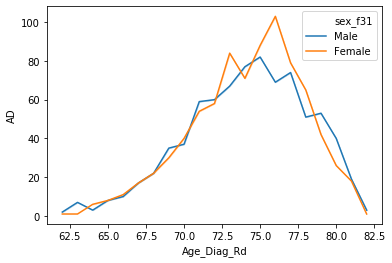

In [370]:
sns.lineplot(data=ukb_shap[['Age_Diag_Rd','AD','sex_f31']][mask], x='Age_Diag_Rd', y='AD',hue='sex_f31',estimator='sum')
plt.show()

In [371]:
def summariseAD(var,df=ukb_shap,agg='mean'):
    return df.groupby(var)['AD'].agg({'AD':[agg]})

In [372]:
#for col in modriskfactors:
 #   if col!='eid':
 #       summariseAD(col).plot(kind='bar')

In [373]:
import numpy as np
import scipy
import scipy.stats

from scipy import stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

apoe_mask=(ukb_shap['Genotype']=="e4/e4")|(ukb_shap['Genotype']=="e3/e4")|(ukb_shap['Genotype']=="e2/e4")
age_mask=(ukb_shap['Age_Today']>70)

apoe_set=ukb_shap['Age_Today'][apoe_mask&age_mask]
non_apoe_set=ukb_shap['Age_Today'][~apoe_mask&age_mask]

stats.ttest_ind(apoe_set,non_apoe_set, equal_var = False)

print(mean_confidence_interval(apoe_set))
print(mean_confidence_interval(non_apoe_set))

(75.42231989793062, 75.393175441669, 75.45146435419224)
(75.4454113375496, 75.42708180094094, 75.46374087415826)


In [374]:
varssum=['Risk_Group','Genotype','particulate_matter_air_pollution_pm25_2010_f24006',
       'mean_time_to_correctly_identify_matches_f20023','urea_f30670','alan_aspar_rat',
       'number_of_treatmentsmedications_taken_f137','nitrogen_dioxide_air_pollution_2006_f24017',
       'sleeplessness_insomnia_f1200',
       'particulate_matter_air_pollution_pm25_absorbance_2010_f24007','mean_corpuscular_volume_f30040',
       'parental_ad_status',
       'alanine_aminotransferase_f30620','aspartate_aminotransferase_f30650',
       'neutrophill_count_f30140','risk_score','APOE',"AD"]

In [375]:
mask_ap=(ukb_shap['APOE']==1)

pd.DataFrame(ukb_shap[varssum][mask_ap].groupby(['Risk_Group']).mean().transpose())

Risk_Group,,1. High,2. Medium,3. Low
particulate_matter_air_pollution_pm25_2010_f24006,10.066208,9.946596,9.816617,9.841274
mean_time_to_correctly_identify_matches_f20023,569.366572,598.896996,564.048143,540.440270
urea_f30670,5.617950,5.742448,5.545965,5.547247
alan_aspar_rat,1.205201,1.335865,1.259586,1.164474
number_of_treatmentsmedications_taken_f137,2.657821,3.436788,2.516369,1.510086
nitrogen_dioxide_air_pollution_2006_f24017,29.544773,28.494950,27.331434,27.136134
particulate_matter_air_pollution_pm25_absorbance_2010_f24007,1.194177,1.167925,1.149834,1.142425
mean_corpuscular_volume_f30040,91.079576,91.573423,91.318782,90.911508
parental_ad_status,0.158958,0.251310,0.245700,0.115163
alanine_aminotransferase_f30620,23.885545,22.047063,23.272318,24.604115


In [376]:
sumchar=pd.DataFrame(ukb_shap[(ukb_shap['Age_Today']>70)].groupby(['AD','APOE'])['Age_Today'].\
agg({'mean_age':'mean','std_age':'std','recs':'count'})).reset_index()

sumchar['lb_age']=sumchar['mean_age']-sumchar['std_age']
sumchar['ub_age']=sumchar['mean_age']+sumchar['std_age']

sumchar['age']=round(sumchar['mean_age'],1).astype(str)+' +/- '+round(sumchar['std_age'],1).astype(str)

AD_mask=(sumchar['AD']==1)
APOE_mask=(sumchar['APOE']==1)
sumchar['Type']='Control'
sumchar['Type'][AD_mask]='AD'

sumchar['APOE4 Carrier']='No'
sumchar['APOE4 Carrier'][APOE_mask]='Yes'


sumchar[['Type','APOE4 Carrier','age']]

,Type,APOE4 Carrier,age
0,Control,No,75.4 +/- 3.2
1,Control,Yes,75.4 +/- 3.2
2,AD,No,77.4 +/- 3.1
3,AD,Yes,77.6 +/- 2.9


In [377]:
from scipy.stats import t


In [1]:
from scipy import stats
def pvalue_slopes(df,var):
    
    mask_aspnnull=(pd.notnull(ukb_shap[var]))
    apoe_mask=(df['Genotype']=="e4/e4")|(df['Genotype']=="e3/e4")|(df['Genotype']=="e2/e4")
    
    rng_apoe=(df[mask_aspnnull&apoe_mask][var].max()-df[mask_aspnnull&apoe_mask][var].min())
    
    slope_ap, intercept_ap, r_value_ap, p_value_ap, std_err_ap = \
    stats.linregress(ukb_shap[mask_aspnnull&apoe_mask][var],ukb_shap[mask_aspnnull&apoe_mask]['AD'])
    
    slope_ap_fin=slope_ap*rng_apoe
    
    x=ukb_shap[mask_aspnnull&apoe_mask][var]
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    apoe_CI=ts*std_err_ap*rng_apoe

    
    #from scipy.stats import t
    #tinv = lambda p, df: abs(t.ppf(p/2, df)
    
        #print(slope_ap)
    rng_nonapoe=ukb_shap[mask_aspnnull&~apoe_mask][var].max()-ukb_shap[mask_aspnnull&~apoe_mask][var].min()
    
    slope_nonap, intercept_nonap, r_value_nonap, p_value_nonap, std_err_nonap = \
    stats.linregress(ukb_shap[mask_aspnnull&~apoe_mask][var],ukb_shap[mask_aspnnull&~apoe_mask]['AD'])
    #print(slope_nonap)
    
    slope_nonap_fin=slope_nonap*rng_nonapoe
    
    x=ukb_shap[mask_aspnnull&~apoe_mask][var]
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    nonapoe_CI=ts*std_err_ap*rng_nonapoe

    numerator = slope_ap - slope_nonap
    denominator = pow((pow(std_err_ap,2) + pow(std_err_nonap,2)), 1/2)
    z=numerator/denominator  
    #print(z)

    p_value = stats.norm.sf(abs(z))
    print(slope_ap_fin-slope_nonap_fin)
    
    
    return slope_ap_fin,slope_nonap_fin,p_value,apoe_CI,nonapoe_CI,p_value_ap,p_value_nonap
    

In [59]:
def lines_conf(var,df=ukb_shap,minsamp=2000,regplot=0,rounded=1,factdiv=1,riskscore=0,rat='subt',e4e4=0):
    ukb_shap_var=df[['eid',var,'APOE','Genotype','AD','risk_score_norm']]
    
    mask=(ukb_shap_var['APOE']==1)
    maske4=(ukb_shap_var['Genotype']=='e4/e4')
    ukb_shap_var['APOE Status']=ukb_shap_var['APOE']
    
    ukb_shap_var['APOE Status'][~mask]='Non APOE4 Carriers'
    if e4e4==1:
        ukb_shap_var['APOE Status'][mask]='Single APOE4 Carriers'
        ukb_shap_var['APOE Status'][maske4]='APOE4 Carriers e4/e4'
        
    else:
        ukb_shap_var['APOE Status'][mask]='APOE4 Carriers'
    
    
    
    ukb_shap_var[var+'rounded']=round(ukb_shap_var[var]/factdiv,rounded)*factdiv
    dfgp=pd.DataFrame(ukb_shap_var.groupby(['APOE Status',var+'rounded']).agg({'AD':['mean','count','sum']})).reset_index()
    dfgp.columns=['APOE Status',var+'rounded','AD Incidence Rate','recs','total_AD']
    mask=(dfgp['recs']>=minsamp)
    dfgp=dfgp[mask]
    ukb_shap_var=pd.merge(ukb_shap_var,dfgp,on=['APOE Status',var+'rounded'],how='inner')
    
    if e4e4==1:
        maskapoe=(dfgp['APOE Status']=='Single APOE4 Carriers')|(dfgp['APOE Status']=='APOE4 Carriers e4/e4')
    else:
        maskapoe=(dfgp['APOE Status']=='APOE4 Carriers')
    
    dfgp_apoe=dfgp[maskapoe]
    dfgp_apoe.rename(columns={'AD Incidence Rate':'APOERate'},inplace=True)
    dfgp_non_apoe=dfgp[~maskapoe]
    dfgp_non_apoe.rename(columns={'AD Incidence Rate':'nonAPOERate'},inplace=True)
    df_gp_apoenon=pd.merge(dfgp_apoe[[var+'rounded','APOERate']],
                           dfgp_non_apoe[[var+'rounded','nonAPOERate']],on=var+'rounded',how='inner')
    
    if rat=='mult':
        yname='Ratio: APOE4 to non APOE4 Incidence'
        df_gp_apoenon[yname]=df_gp_apoenon['APOERate']/df_gp_apoenon['nonAPOERate']
    elif rat=='subt':
        yname='Difference: APOE4 - non APOE4 Incidence'
        df_gp_apoenon[yname]=df_gp_apoenon['APOERate']-df_gp_apoenon['nonAPOERate']
    
    
    plt.show()
    
    if riskscore==0:
        ax=sns.lineplot(data=ukb_shap_var, x=var+'rounded', y='AD',hue='APOE Status',estimator='mean')
        ax.set(xlabel=var,ylabel='AD Incidence Rate')
        plt.show()
    if riskscore==1:
        ax=sns.lineplot(data=ukb_shap_var, x=var+'rounded', y='risk_score_norm',hue='APOE Status',estimator='mean')
        ax.set(xlabel=var,ylabel='AD Risk Score')
        plt.show()
        
    
    if regplot==1:
        #sns.lineplot(data=df_gp_apoenon, x=var+'rounded', y='ratio',estimator='mean')
        sns.regplot(data=df_gp_apoenon, x=var+'rounded', y=yname)
        plt.show()
        
        slope, intercept, r_value, p_value, std_err = \
        stats.linregress(df_gp_apoenon[var+'rounded'],df_gp_apoenon[yname])

        x=df_gp_apoenon[var+'rounded']
        tinv = lambda p, df: abs(t.ppf(p/2, df))
        ts = tinv(0.05, len(x)-2)
        slope_CI=ts*std_err
        print(f"slope (95%): {slope:.6f} +/- {slope_CI:.6f}")
        #sns.regplot(data=dfgp, x=var+'rounded', y='AD Incidence Rate')
        #plt.show()
    else:
        sns.lineplot(data=df_gp_apoenon, x=var+'rounded', y=yname,estimator='mean')
    #plt.show()
    

In [60]:
mask_geno=(pd.notnull(ukb_shap['Genotype']))
ukb_shap_geno=ukb_shap[mask_geno]

In [61]:
mask_sleep=(ukb_shap_geno['sleeplessness_insomnia_f1200'].isin(['Sometimes','Usually','Prefer not to answer']))
mask_diet=(ukb_shap_geno['never_eat_eggs_dairy_wheat_sugar_f6144'].isin(['I eat all of the above']))

In [62]:
ukb_shap_geno['sleeplessness']='Never'
ukb_shap_geno['sleeplessness'][mask_sleep]='Sometimes'
ukb_shap_geno['Diet']='Compromised'
ukb_shap_geno['Diet'][mask_diet]='All'

In [63]:
findcols(ukb_shap_geno,'sleep')

['sleep_duration_f1160', 'sleeplessness_insomnia_f1200', 'sleeplessness']

In [64]:
ukb_shap_geno.groupby(['sleeplessness_insomnia_f1200'])['sleep_duration_f1160'].mean()

sleeplessness_insomnia_f1200
Never/rarely            7.511201
Prefer not to answer    4.364103
Sometimes               7.328969
Usually                 6.645519
Name: sleep_duration_f1160, dtype: float64

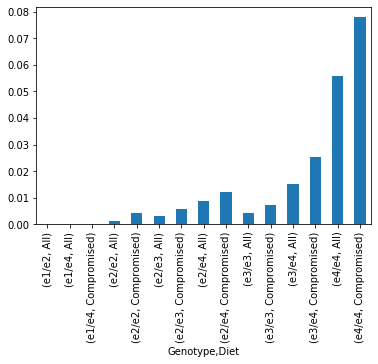

In [65]:
ukb_shap_geno.groupby(['Genotype','Diet'])['AD'].mean().plot(kind='bar')

In [66]:
varsloop=['Age_Today','alan_aspar_rat','alanine_aminotransferase_f30620',
          'number_of_treatmentsmedications_taken_f137','mean_time_to_correctly_identify_matches_f20023',
          'CERVASCALL_bef','urea_f30670','particulate_matter_air_pollution_pm25_2010_f24006',
         'creactive_protein_f30710']
varnames=['Age','ALT:AST Ratio','ALT','number of treatments/medications','mean time to identify matches',
         'cerebrovascular disease','urea','particulate_matter_air_pollution','creactive_protein']

In [67]:
apoe_slope_arr=np.asarray([])
non_apoe_slope_arr=np.asarray([])
pvalue_arr=np.asarray([])
apoe_CI_arr=np.asarray([])
non_apoe_CI_arr=np.asarray([])


varname_arr=np.asarray([])


for i,var in enumerate(varsloop):
    apoe_slope=round(pvalue_slopes(ukb_shap,var)[0],4)
    non_apoe_slope=round(pvalue_slopes(ukb_shap,var)[1],4)
    pvalue=pvalue_slopes(ukb_shap,var)[2]
    apoe_CI=pvalue_slopes(ukb_shap,var)[3]
    non_apoe_CI=pvalue_slopes(ukb_shap,var)[4]
    
    if round(pvalue,4)!=0:
        pvalue=round(pvalue,5)
        
    
    apoe_slope_arr=np.append(apoe_slope_arr,apoe_slope)
    non_apoe_slope_arr=np.append(non_apoe_slope_arr,non_apoe_slope)
    apoe_CI_arr=np.append(apoe_CI_arr,apoe_CI)
    non_apoe_CI_arr=np.append(non_apoe_CI_arr,non_apoe_CI)
    pvalue_arr=np.append(pvalue_arr,pvalue)
    varname_arr=np.append(varname_arr,varnames[i])
    
df1=pd.DataFrame({'variable':varname_arr,'apoe_slope':apoe_slope_arr,'apoe_CI':apoe_CI_arr,'non_apoe_CI':non_apoe_CI_arr,
                  'non_apoe_slope':non_apoe_slope_arr,'pvalue':pvalue_arr})

df1['apoe_slope']=df1['apoe_slope'].astype(str)+'+/-'+round(df1['apoe_CI'],4).astype(str)
df1['non_apoe_slope']=df1['non_apoe_slope'].astype(str)+'+/-'+round(df1['non_apoe_CI'],4).astype(str)

0.049629638734396256
0.049629638734396256
0.049629638734396256
0.049629638734396256
0.049629638734396256
0.07509365929774486
0.07509365929774486
0.07509365929774486


KeyboardInterrupt: 

In [68]:
ukb_shap_geno['testosterone_f30850'].sample(20)



167497     1.055
28698      0.630
115054    10.098
16167      1.702
156217    15.638
72998     10.219
122964    17.726
14607      1.009
133392     0.634
18580      1.394
118039    10.140
69528      0.393
69957        NaN
115963     1.012
159915       NaN
71140     13.084
44441     10.079
1421       0.833
93330      0.952
152190     6.916
Name: testosterone_f30850, dtype: float64

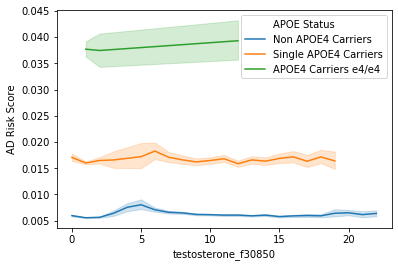

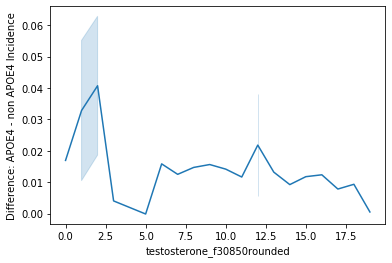

In [69]:
mask_test=pd.notnull(ukb_shap_geno['testosterone_f30850'])
lines_conf('testosterone_f30850',df=ukb_shap_geno[mask_test],minsamp=200,rounded=2,factdiv=100,regplot=0,e4e4=1,riskscore=1)

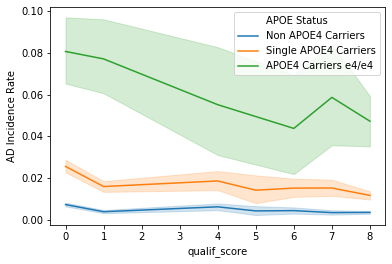

-0.009417113348696842


(-0.012093734711279757,
 -0.0026766213625829156,
 2.3923605366847835e-09,
 0.0030175920860992626,
 0.0030175462896902512,
 4.072220927577284e-15,
 9.211019568343174e-09)

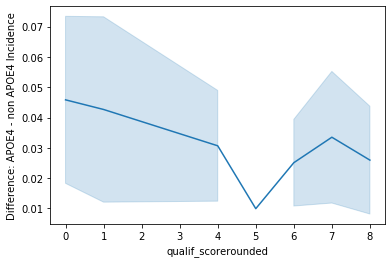

In [70]:
lines_conf('qualif_score',df=ukb_shap_geno,minsamp=200,rounded=1,regplot=0,e4e4=1,riskscore=0)
pvalue_slopes(ukb_shap_geno,'qualif_score')

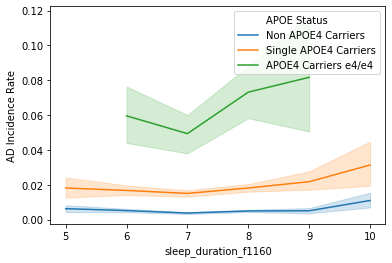

0.010275069834737992


(0.011254193112039533,
 0.0009791232773015406,
 0.0010529053358437827,
 0.0062762090806957205,
 0.006276111874935175,
 0.00044082429686970675,
 0.30543097549099196)

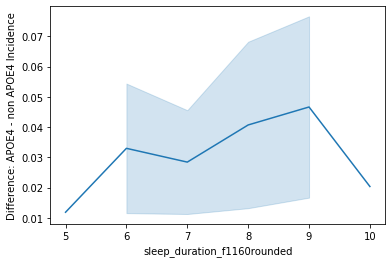

In [71]:
mask_sleep=(ukb_shap_geno['sleep_duration_f1160'].between(5,10))
lines_conf('sleep_duration_f1160',df=ukb_shap_geno[mask_sleep],minsamp=200,rounded=10,regplot=0,e4e4=1,riskscore=0)
pvalue_slopes(ukb_shap_geno[mask_sleep],'sleep_duration_f1160')

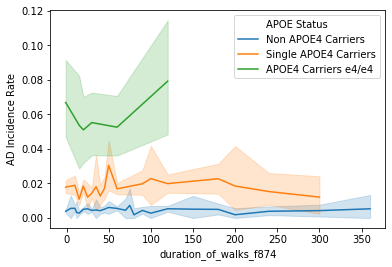

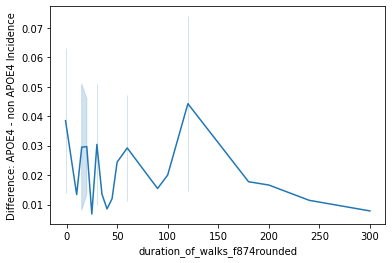

In [73]:
lines_conf('duration_of_walks_f874',df=ukb_shap_geno,minsamp=200,rounded=10,regplot=0,e4e4=1,riskscore=0)


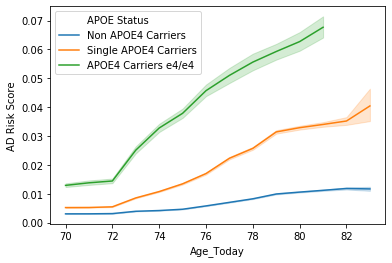

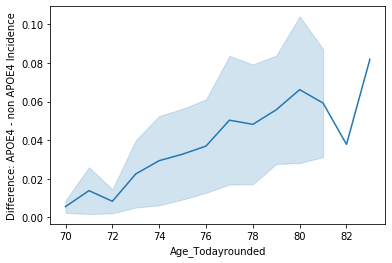

In [74]:
lines_conf('Age_Today',df=ukb_shap_geno,minsamp=100,rounded=0,regplot=0,e4e4=1,riskscore=1)


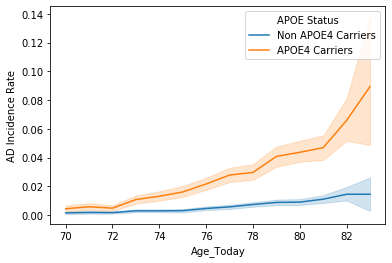

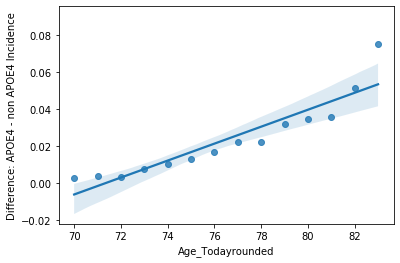

slope (95%): 0.004576 +/- 0.001183


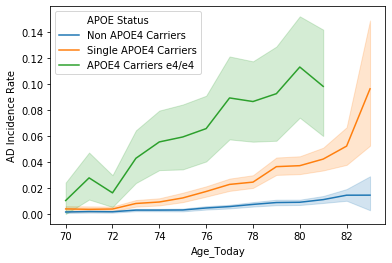

0.049629638734396256


(0.06253032898166842,
 0.012900690247272166,
 1.9227002296047466e-68,
 0.005333129694505798,
 0.005326782115066488,
 3.033398526152502e-116,
 9.318979689781638e-55)

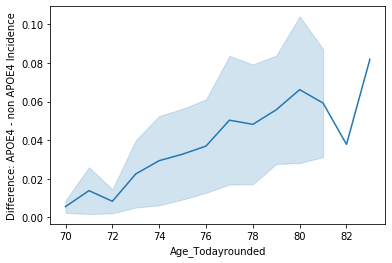

In [75]:
lines_conf('Age_Today',df=ukb_shap_geno,minsamp=100,rounded=0,regplot=1)
lines_conf('Age_Today',df=ukb_shap_geno,minsamp=100,rounded=0,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap_geno,'Age_Today')

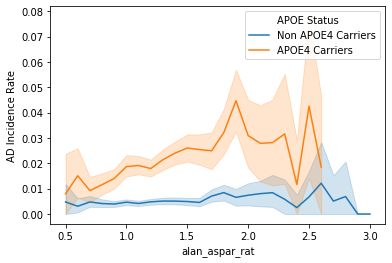

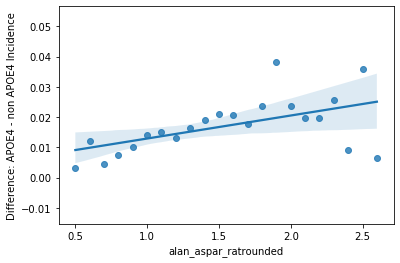

slope (95%): 0.007604 +/- 0.005474


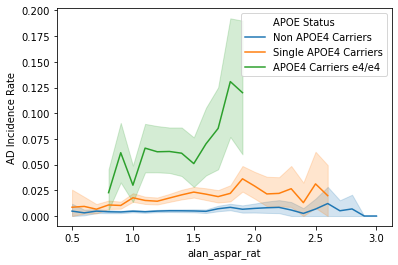

0.07509365929774486


(0.0878658738068163,
 0.012772214509071445,
 7.094220764498221e-12,
 0.021964531782376458,
 0.03231872315007866,
 4.574431808547271e-15,
 0.011499252983904194)

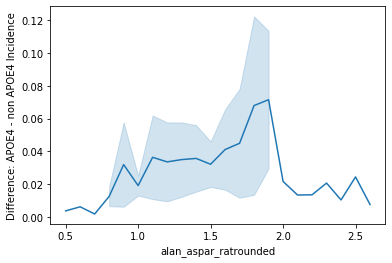

In [76]:
lines_conf('alan_aspar_rat',df=ukb_shap_geno,minsamp=100,riskscore=0,regplot=1)
lines_conf('alan_aspar_rat',df=ukb_shap_geno,minsamp=100,riskscore=0,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap_geno,'alan_aspar_rat')

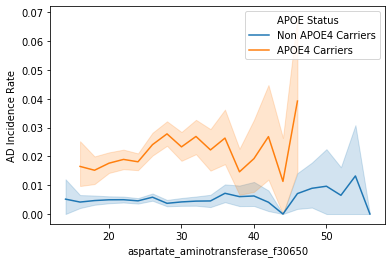

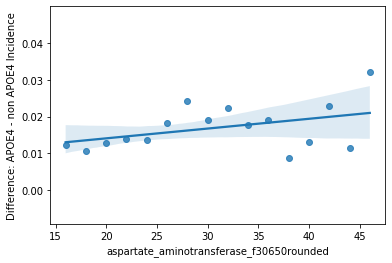

slope (95%): 0.000266 +/- 0.000340


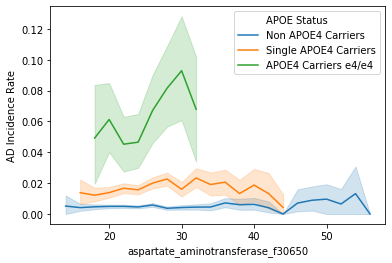

0.08326451584782957


(0.11277307687746298,
 0.029508561029633413,
 0.056059058192329404,
 0.09527645368713256,
 0.08765185181787881,
 0.020347722453063904,
 0.02947609276400401)

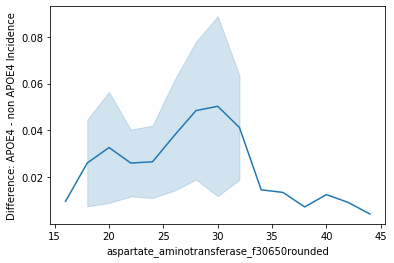

In [77]:
lines_conf('aspartate_aminotransferase_f30650',df=ukb_shap_geno,minsamp=200,factdiv=20,riskscore=0,regplot=1)
lines_conf('aspartate_aminotransferase_f30650',df=ukb_shap_geno,minsamp=200,factdiv=20,riskscore=0,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap_geno,'aspartate_aminotransferase_f30650')

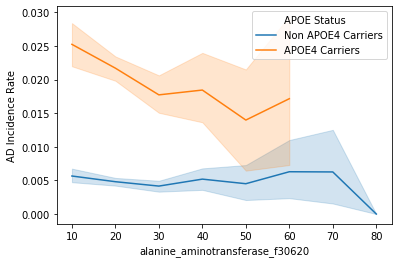

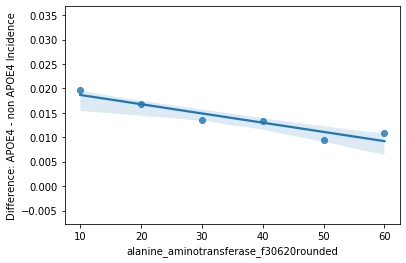

slope (95%): -0.000189 +/- 0.000094


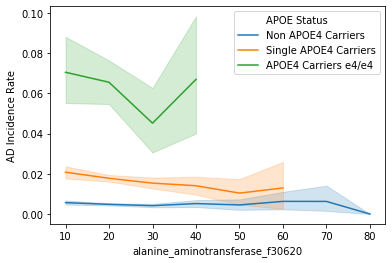

-0.07374188489659032


(-0.07687322716546141,
 -0.0031313422688710887,
 0.0012345926857122496,
 0.046136325403220775,
 0.05234359386055108,
 0.0010922906585684397,
 0.681956559575748)

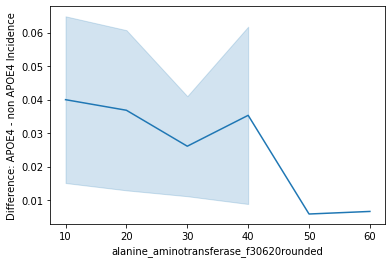

In [78]:
lines_conf('alanine_aminotransferase_f30620',minsamp=200,rounded=0,factdiv=10,regplot=1)
lines_conf('alanine_aminotransferase_f30620',minsamp=200,rounded=0,factdiv=10,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap,'alanine_aminotransferase_f30620')

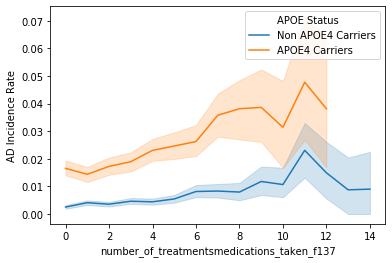

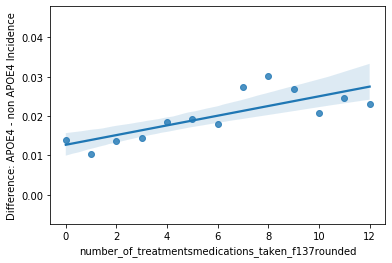

slope (95%): 0.001233 +/- 0.000643


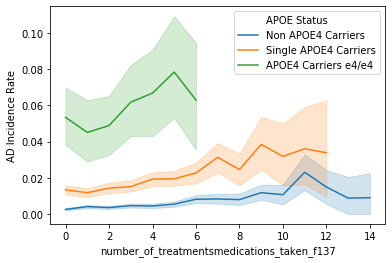

0.04341270440932596


(0.07084097599826691,
 0.027428271588940952,
 7.317988665462045e-12,
 0.012795743971220165,
 0.014166501927744072,
 2.1163936853813633e-27,
 9.396853366664553e-36)

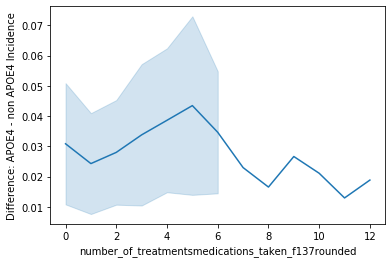

In [79]:
lines_conf('number_of_treatmentsmedications_taken_f137',df=ukb_shap_geno,minsamp=200,regplot=1)
lines_conf('number_of_treatmentsmedications_taken_f137',df=ukb_shap_geno,minsamp=200,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap_geno,'number_of_treatmentsmedications_taken_f137')

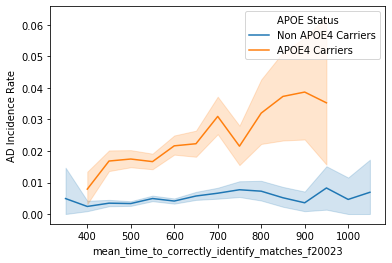

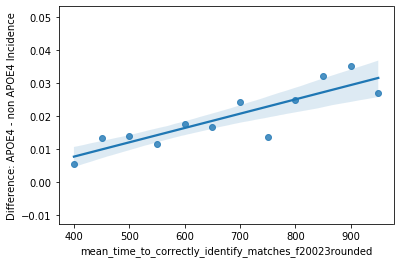

slope (95%): 0.000043 +/- 0.000017


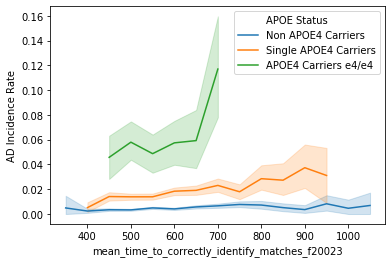

0.0649640885199835


(0.08701903803780561,
 0.022054949517822102,
 3.4277639963021547e-12,
 0.01828707728083247,
 0.01996176171611027,
 1.1369008503496644e-20,
 4.62407749450691e-13)

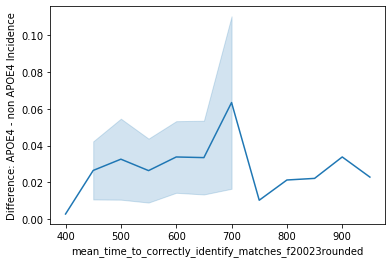

In [80]:
lines_conf('mean_time_to_correctly_identify_matches_f20023',df=ukb_shap_geno,minsamp=200,rounded=0,factdiv=50,regplot=1)
lines_conf('mean_time_to_correctly_identify_matches_f20023',df=ukb_shap_geno,minsamp=200,rounded=0,factdiv=50,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap_geno,'mean_time_to_correctly_identify_matches_f20023')

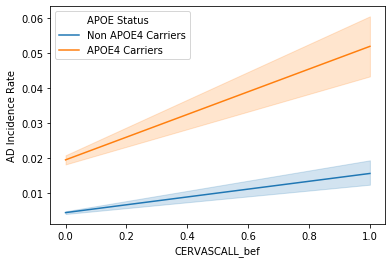

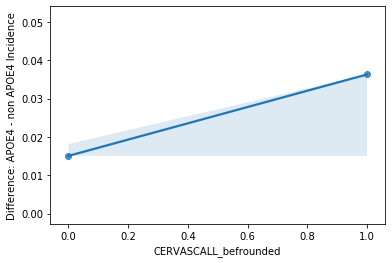

slope (95%): 0.021246 +/- nan


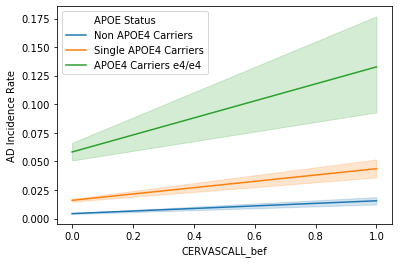

0.021245766955541374


(0.032433253174422756,
 0.011187486218881383,
 5.093772014117606e-12,
 0.005829609246996935,
 0.0058295209502392245,
 1.1798511042676055e-27,
 6.261600002050355e-32)

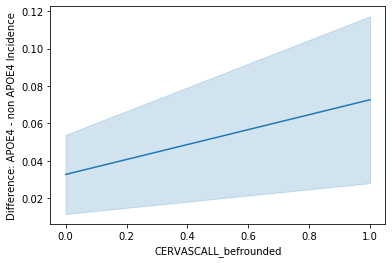

In [81]:
lines_conf('CERVASCALL_bef',minsamp=1000,df=ukb_shap_geno,rounded=1,factdiv=1,regplot=1)
lines_conf('CERVASCALL_bef',minsamp=100,df=ukb_shap_geno,rounded=1,factdiv=1,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap_geno,'CERVASCALL_bef')

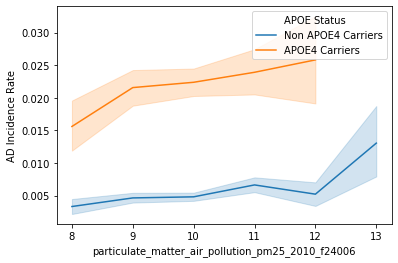

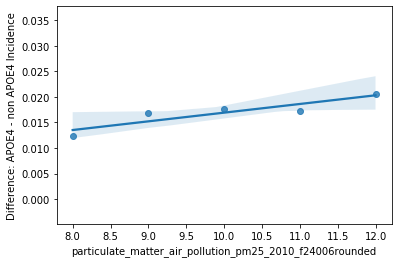

slope (95%): 0.001698 +/- 0.001508


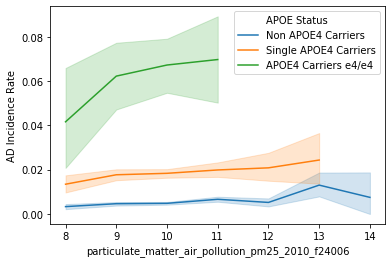

0.01074855660098186


(0.023738261974908047,
 0.012989705373926188,
 0.03759539404911288,
 0.01372191416052566,
 0.016625117484736194,
 0.0006976541650581897,
 4.4482062209423185e-07)

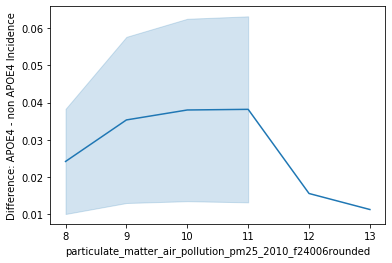

In [82]:
lines_conf('particulate_matter_air_pollution_pm25_2010_f24006',df=ukb_shap_geno,minsamp=1000,rounded=0,factdiv=1,regplot=1)
lines_conf('particulate_matter_air_pollution_pm25_2010_f24006',df=ukb_shap_geno,minsamp=200,rounded=0,factdiv=1,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap_geno,'particulate_matter_air_pollution_pm25_2010_f24006')

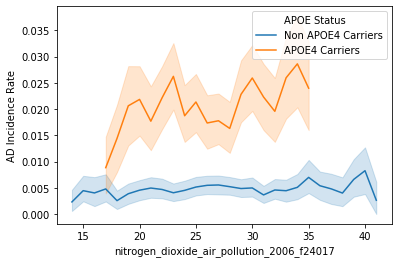

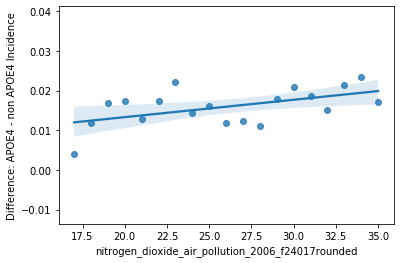

slope (95%): 0.000439 +/- 0.000363


In [ ]:
lines_conf('nitrogen_dioxide_air_pollution_2006_f24017',df=ukb_shap_geno,minsamp=1000,rounded=0,factdiv=1,regplot=1)
lines_conf('nitrogen_dioxide_air_pollution_2006_f24017',df=ukb_shap_geno,minsamp=200,rounded=0,factdiv=1,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap_geno,'nitrogen_dioxide_air_pollution_2006_f24017')

In [ ]:
lines_conf('urea_f30670',df=ukb_shap_geno,minsamp=1000,rounded=0,factdiv=1,regplot=1)
lines_conf('urea_f30670',df=ukb_shap_geno,minsamp=200,rounded=0,factdiv=1,regplot=0,e4e4=1)
pvalue_slopes(ukb_shap_geno,'urea_f30670')

In [ ]:
lines_conf('met_minutes_per_week_for_walking_f22037',minsamp=1000,rounded=0,regplot=1,factdiv=250,riskscore=1)

In [ ]:
lines_conf('time_spent_driving_f1090',minsamp=500,rounded=0,regplot=1,factdiv=1,riskscore=1)

In [119]:
varsloop=\
['Age_Today','alan_aspar_rat','aspartate_aminotransferase_f30650','alanine_aminotransferase_f30620',
'number_of_treatmentsmedications_taken_f137','mean_time_to_correctly_identify_matches_f20023',
'CERVASCALL_bef','particulate_matter_air_pollution_pm25_2010_f24006','nitrogen_dioxide_air_pollution_2006_f24017',
'urea_f30670','aspartate_aminotransferase_f30650','sleep_duration_f1160','qualif_score']

In [120]:
pvalues_all = {'Risk Factor':  varsloop,
        'APOE4+ve slope': [pvalue_slopes(ukb_shap_geno,var)[0] for var in varsloop],
        'APOE4-ve slope': [pvalue_slopes(ukb_shap_geno,var)[1] for var in varsloop],
        'APOE4+ve slope p value': [pvalue_slopes(ukb_shap_geno,var)[5] for var in varsloop],
        'APOE4-ve slope p value': [pvalue_slopes(ukb_shap_geno,var)[6] for var in varsloop],
        'APOE4+ve - APOE-ve slope p value': [pvalue_slopes(ukb_shap_geno,var)[2] for var in varsloop]}



0.049629638734396256
0.07509365929774486
0.08326451584782957
-0.07374188489659032
0.04341270440932596
0.0649640885199835
0.021245766955541374
0.01074855660098186
0.026701134441089146
-0.01191225952469046
0.08326451584782957
0.02444507545895131
-0.009417113348696842
0.049629638734396256
0.07509365929774486
0.08326451584782957
-0.07374188489659032
0.04341270440932596
0.0649640885199835
0.021245766955541374
0.01074855660098186
0.026701134441089146
-0.01191225952469046
0.08326451584782957
0.02444507545895131
-0.009417113348696842
0.049629638734396256
0.07509365929774486
0.08326451584782957
-0.07374188489659032
0.04341270440932596
0.0649640885199835
0.021245766955541374
0.01074855660098186
0.026701134441089146
-0.01191225952469046
0.08326451584782957
0.02444507545895131
-0.009417113348696842
0.049629638734396256
0.07509365929774486
0.08326451584782957
-0.07374188489659032
0.04341270440932596
0.0649640885199835
0.021245766955541374
0.01074855660098186
0.026701134441089146
-0.0119122595246904

In [121]:
df_pvalueslopes = pd.DataFrame (pvalues_all, columns = ['Risk Factor','APOE4+ve slope','APOE4-ve slope',
                                                'APOE4+ve slope p value','APOE4-ve slope p value',
                                                'APOE4+ve - APOE-ve slope p value'])

df_pvalueslopes

,Risk Factor,APOE4+ve slope,APOE4-ve slope,APOE4+ve slope p value,APOE4-ve slope p value,APOE4+ve - APOE-ve slope p value
0,Age_Today,0.062530,0.012901,3.033399e-116,9.318980e-55,1.922700e-68
1,alan_aspar_rat,0.087866,0.012772,4.574432e-15,1.149925e-02,7.094221e-12
2,aspartate_aminotransferase_f30650,0.112773,0.029509,2.034772e-02,2.947609e-02,5.605906e-02
3,alanine_aminotransferase_f30620,-0.076873,-0.003131,1.092291e-03,6.819566e-01,1.234593e-03
4,number_of_treatmentsmedications_taken_f137,0.070841,0.027428,2.116394e-27,9.396853e-36,7.317989e-12
5,mean_time_to_correctly_identify_matches_f20023,0.087019,0.022055,1.136901e-20,4.624077e-13,3.427764e-12
6,CERVASCALL_bef,0.032433,0.011187,1.179851e-27,6.261600e-32,5.093772e-12
7,particulate_matter_air_pollution_pm25_2010_f24006,0.023738,0.012990,6.976542e-04,4.448206e-07,3.759539e-02
8,nitrogen_dioxide_air_pollution_2006_f24017,0.037261,0.010560,3.771074e-05,1.633917e-04,2.246435e-03
9,urea_f30670,0.000316,0.012229,9.837272e-01,1.037058e-02,2.324883e-01


In [124]:
df_pvalueslopes.to_csv('%s%s' % (path,'df_pvalueslopes.csv'))

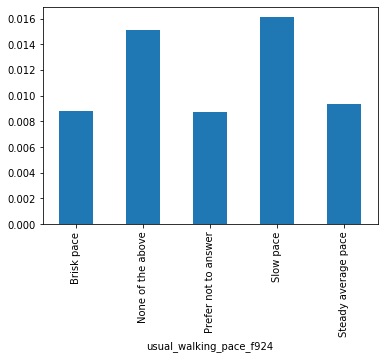

In [822]:
ukb_shap.groupby(['usual_walking_pace_f924'])['AD'].mean().plot(kind='bar')
#ukb_shap.groupby(['usual_walking_pace_f924'])['AD'].size().plot(kind='bar')

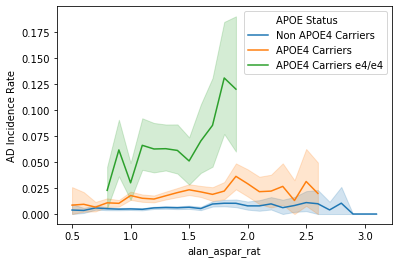

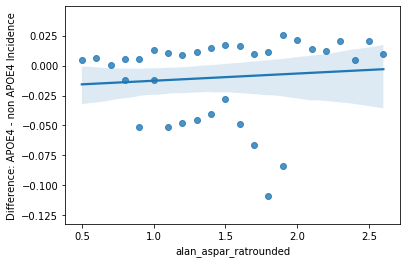

slope (95%): 0.006016 +/- 0.021641


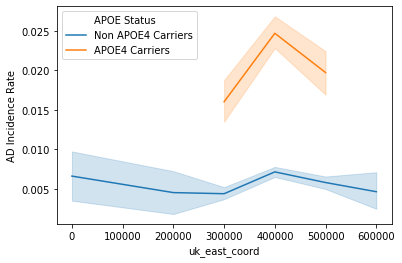

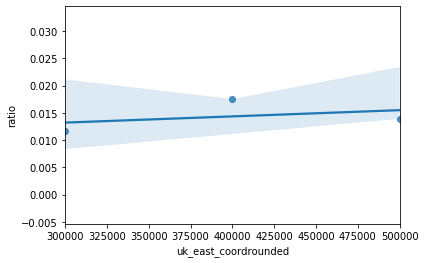

slope (95%): 0.000000 +/- 0.000000


In [768]:
lines_conf('uk_east_coord',minsamp=1000,rounded=0,factdiv=1,regplot=1)

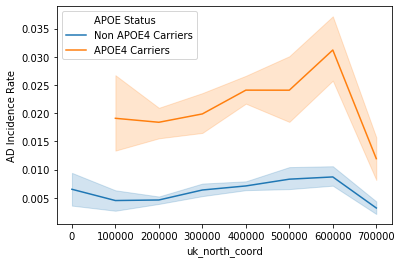

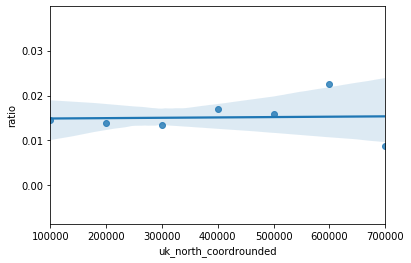

slope (95%): 0.000000 +/- 0.000000


In [769]:

lines_conf('uk_north_coord',minsamp=1000,rounded=0,factdiv=1,regplot=1)


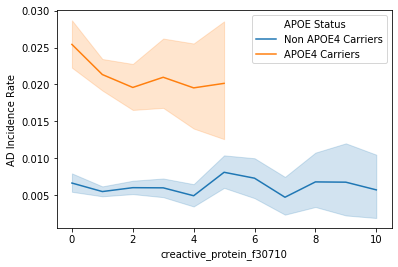

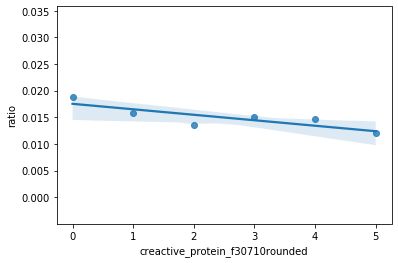

slope (95%): -0.001028 +/- 0.000903


In [770]:
lines_conf('creactive_protein_f30710',minsamp=1000,rounded=0,factdiv=1,regplot=1)

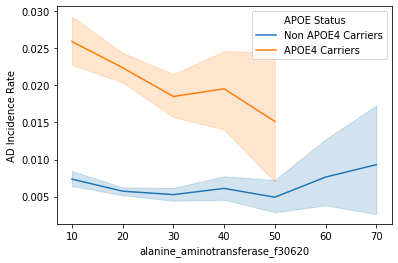

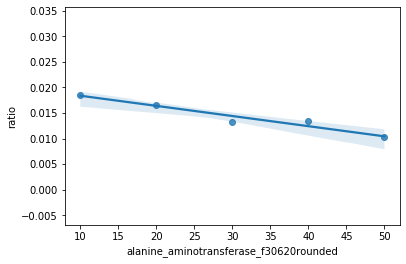

slope (95%): -0.000199 +/- 0.000093


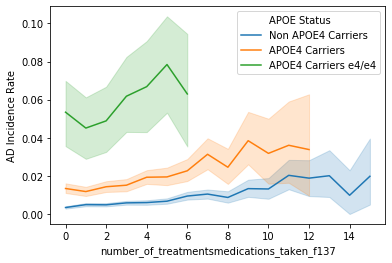

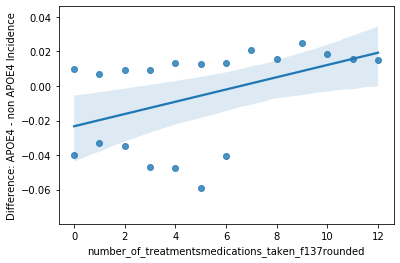

slope (95%): 0.003548 +/- 0.003509


In [874]:
lines_conf('number_of_treatmentsmedications_taken_f137',minsamp=200,regplot=1)

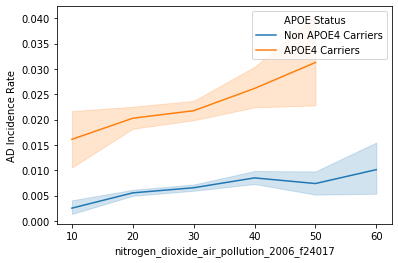

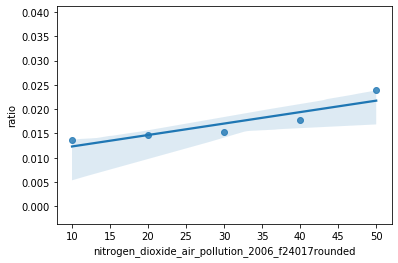

slope (95%): 0.000236 +/- 0.000206


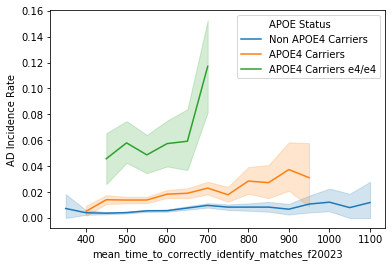

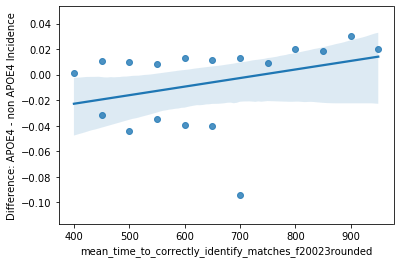

slope (95%): 0.000067 +/- 0.000102


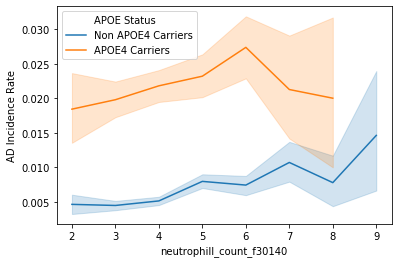

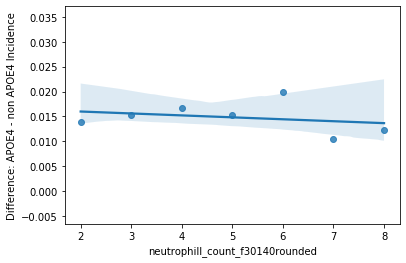

slope (95%): -0.000390 +/- 0.001563


In [780]:
lines_conf('neutrophill_count_f30140',minsamp=500,rounded=0,factdiv=1,regplot=1)

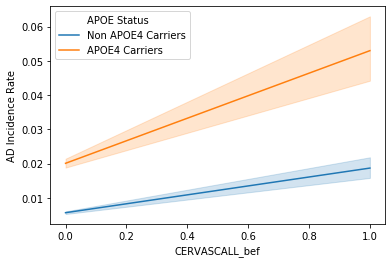

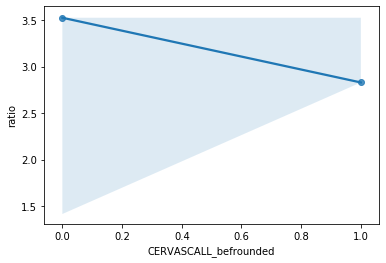

slope (95%): -0.696005 +/- nan


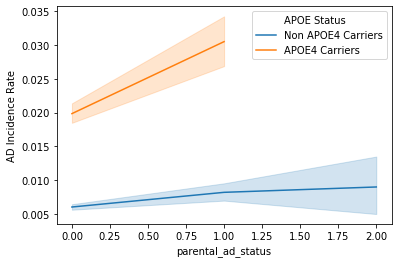

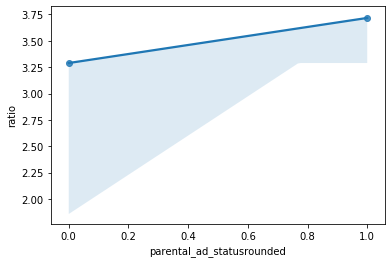

slope (95%): 0.427399 +/- nan


In [729]:
lines_conf('parental_ad_status',minsamp=2000,rounded=0,regplot=1)

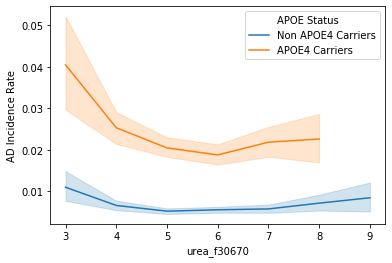

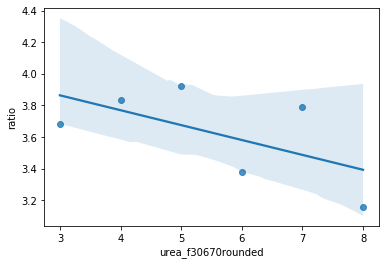

slope (95%): -0.094213 +/- 0.176781


In [730]:
lines_conf('urea_f30670',minsamp=1000,rounded=0,factdiv=1,regplot=1)


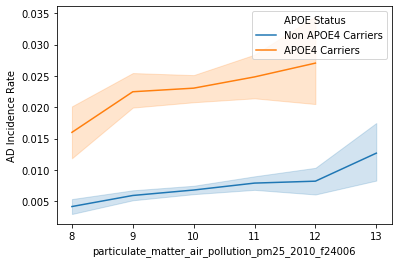

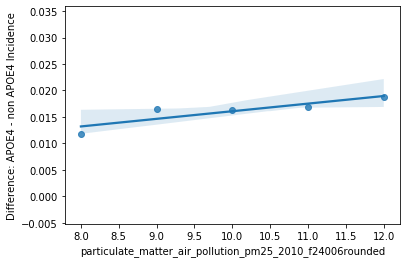

slope (95%): 0.001438 +/- 0.001409


In [781]:
#findcols(ukb_shap,'poll')


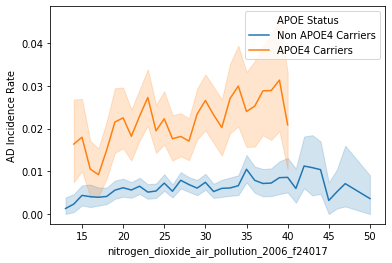

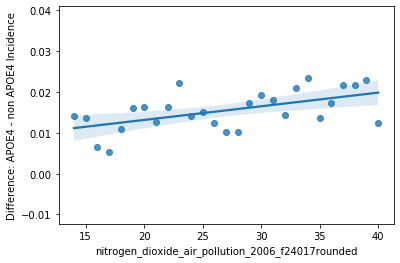

slope (95%): 0.000334 +/- 0.000208


In [782]:
#findcols(ukb_shap,'poll')


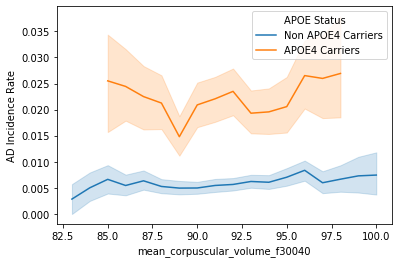

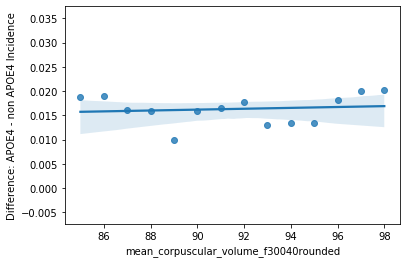

slope (95%): 0.000090 +/- 0.000447


In [783]:
lines_conf('mean_corpuscular_volume_f30040',minsamp=1000,rounded=0,factdiv=1,regplot=1)

In [538]:
findcols(ukb_shap,'neutrophi')

['neutrophill_count_f30140']

Age
AST:ALT


(0.0878658738068163,
 0.02055176124559813,
 1.31317947927811e-10,
 0.021964531782376458,
 0.03231865162826186)

In [412]:
pvalue_slopes(ukb_shap,'parental_ad_status')

(0.022746859961769627, 0.00738177298790145, 0.001775912811409043)

(0.06231043948345492, 0.017641567581860827, 3.767290095300867e-52)

In [414]:
pvalue_slopes(ukb_shap,'alanine_aminotransferase_f30620')

(-0.07396238528092462, -0.004168762831086536, 0.0029811384808023883)

In [415]:
pvalue_slopes(ukb_shap,'mean_corpuscular_volume_f30040')


(0.016549402429009017, 0.014257364617751542, 0.34684205529486833)

In [416]:
pvalue_slopes(ukb_shap,'CERVASCALL_bef')

(0.032866323494333216, 0.013019848593298496, 2.9105875095349667e-10)

In [378]:
pvalue_slopes(ukb_shap,'alanine_aminotransferase_f30620')

(-0.0827565983132417, 0.0032891481297208387, 0.022658872536247408)

In [379]:
pvalue_slopes(ukb_shap,'nitrogen_dioxide_air_pollution_2006_f24017')

(0.06745755636785968, 0.02245181696552291, 0.000261989465428118)

In [505]:
mask_urea=(ukb_shap['urea_f30670']<10)
pvalue_slopes(ukb_shap[(mask_urea)],'urea_f30670')

(-0.00871030947204409, 0.00011126342419463213, 0.03931137372907719)

In [381]:
pvalue_slopes(ukb_shap,'neutrophill_count_f30140')

(0.02358871760505745, 0.0419032666855676, 0.344470163702973)

In [382]:
pvalue_slopes(ukb_shap,'mean_time_to_correctly_identify_matches_f20023')

(0.09053028286501787, 0.04048218685891396, 0.0006083558650179738)

In [204]:
pvalue_slopes(ukb_shap,'urea_f30670')

(-0.00040467883122812415, 9.486866827667166e-05, 0.2821123557786127)

In [224]:
pvalue_slopes(ukb_shap,'number_of_treatmentsmedications_taken_f137')

(0.09242074397941755, 0.034687124765710176, 1.6234015755345207e-07)

In [211]:
pvalue_slopes(ukb_shap,'Age_Today')

(0.006122481228121703, 0.001986583072916756, 1.7725687403670234e-11)

In [214]:
pvalue_slopes(ukb_shap,'CERVASC_bef')

(0.07829763684433223, 0.025759398975073147, 1.7852429762015782e-13)

In [213]:
findcols(ukb_shap,'CERV')

['CERVASC', 'CERVASC_bef']

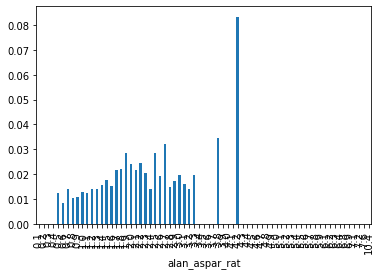

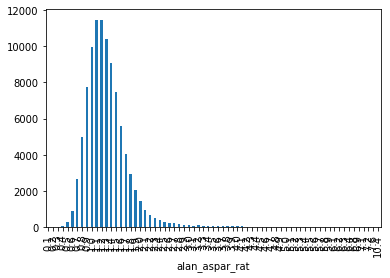

In [134]:
ukb_shap.groupby(['alan_aspar_rat'])['AD'].mean().plot(kind='bar')
plt.show()
ukb_shap.groupby(['alan_aspar_rat']).size().plot(kind='bar')

In [84]:
findcols(ukb_shap,'diabetes')

['diabetes_diagnosed_by_doctor_f2443']

In [85]:
mask_dbd=(ukb_shap['diabetes_diagnosed_by_doctor_f2443']=="Yes")
ukb_shap[['DIAB', 'DIAB_bef','diabetes_diagnosed_by_doctor_f2443']][(mask_dbd)].groupby(['DIAB', 'DIAB_bef']).size()

DIAB  DIAB_bef
0.0   0.0          860
1.0   0.0          144
      1.0         6485
dtype: int64

In [91]:
ukb_shap['AD'][(ukb_shap['DIAB']==0)&mask_dbd].mean()/ukb_shap['AD'].mean()

0.23036621224271586

In [95]:
ukb_shap['AD'][mask_dbd].mean()/ukb_shap['AD'].mean()

1.8782428788276446

In [93]:
ukb_shap['AD'][(ukb_shap['DIAB_bef']==1)].mean()/ukb_shap['AD'].mean()

0.822907341760065

In [ ]:
ukb_shap['eid'][]

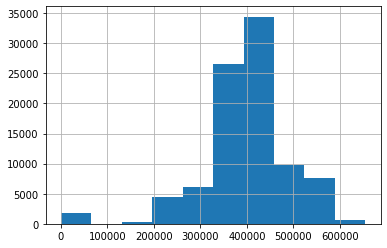

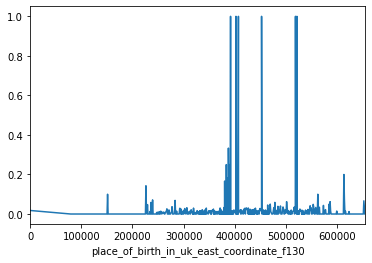

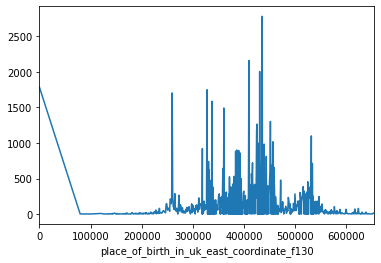

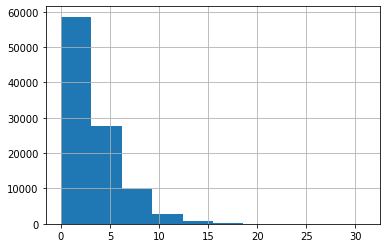

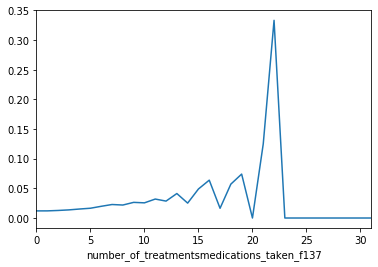

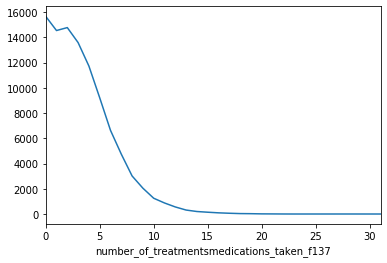

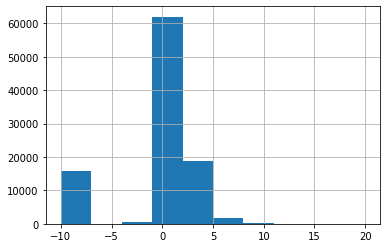

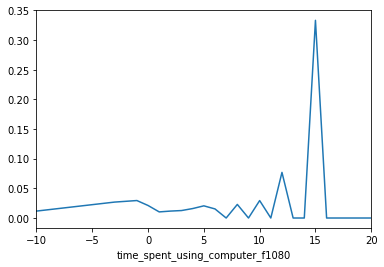

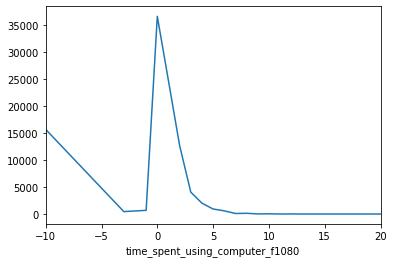

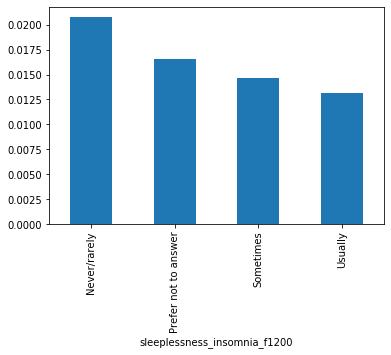

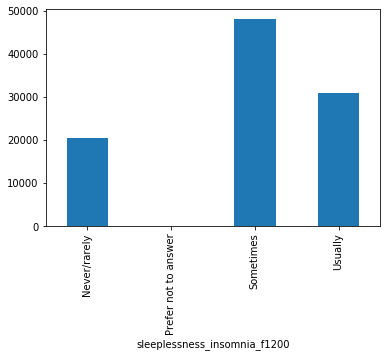

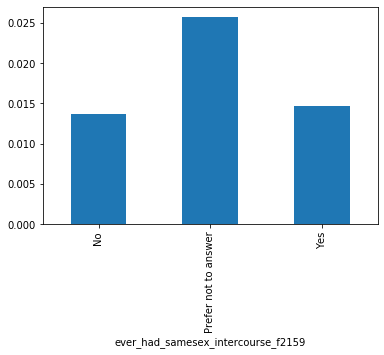

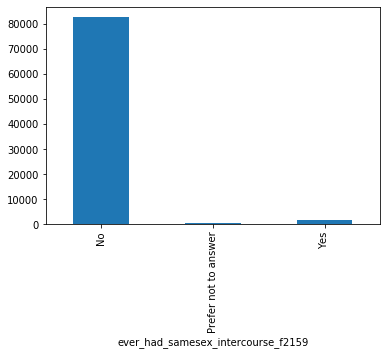

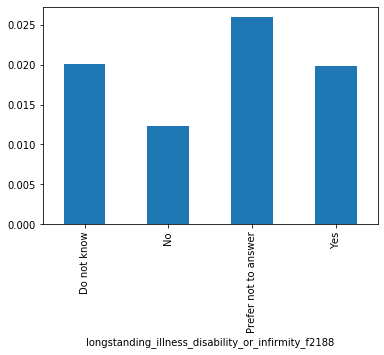

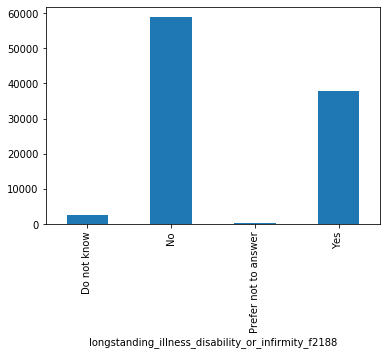

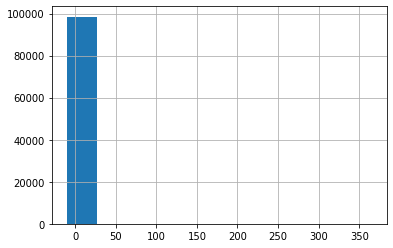

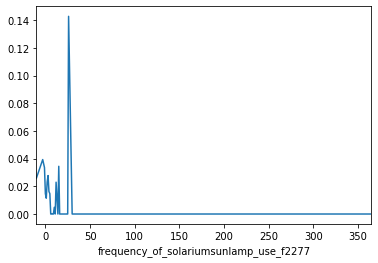

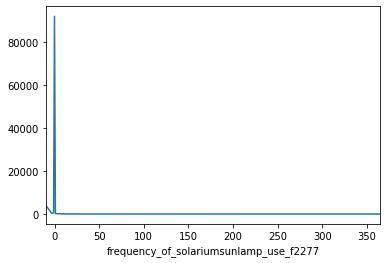

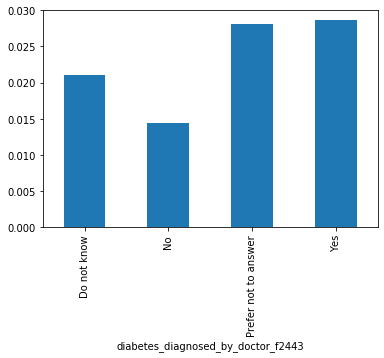

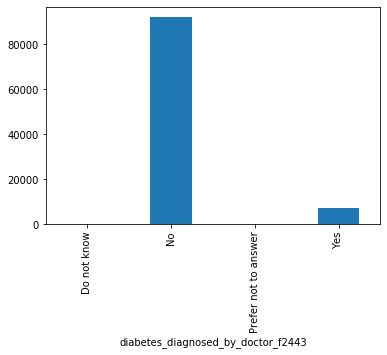

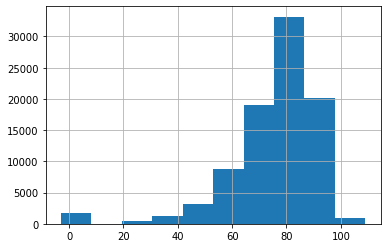

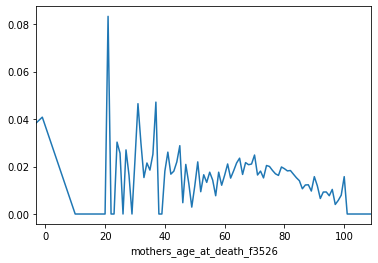

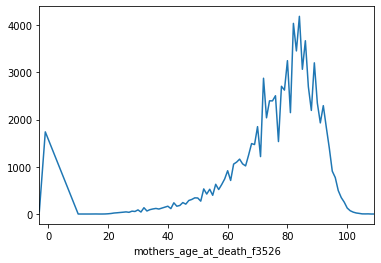

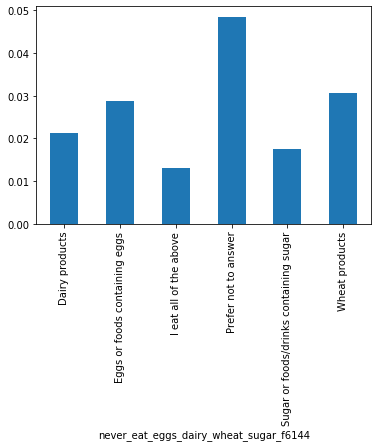

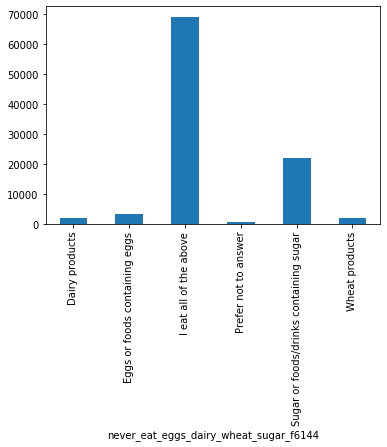

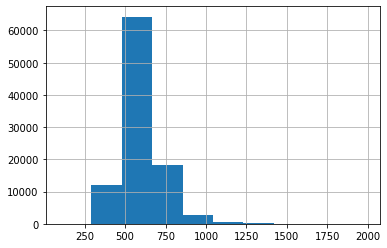

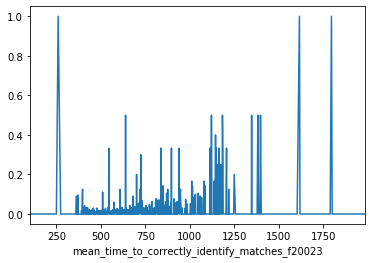

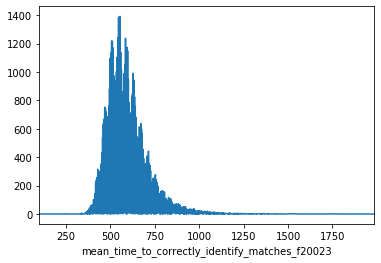

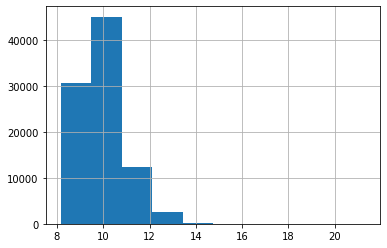

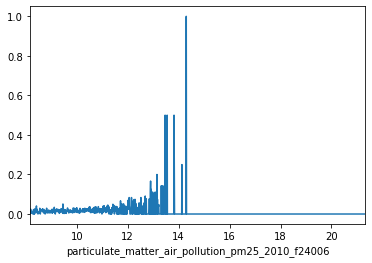

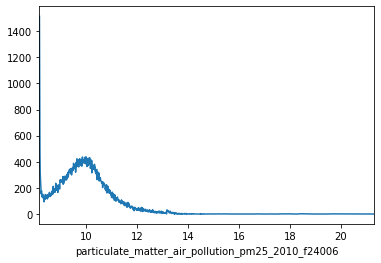

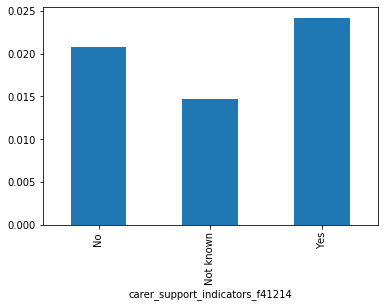

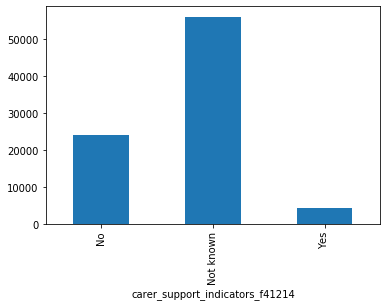

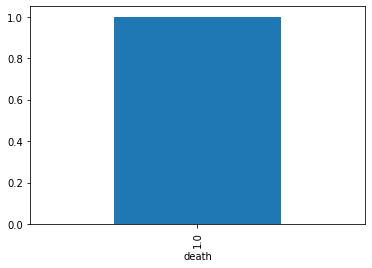

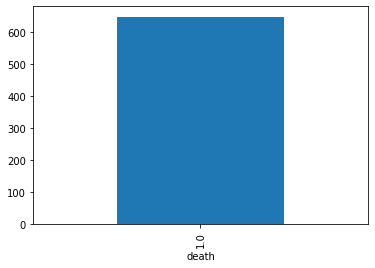

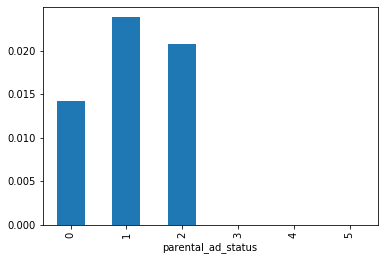

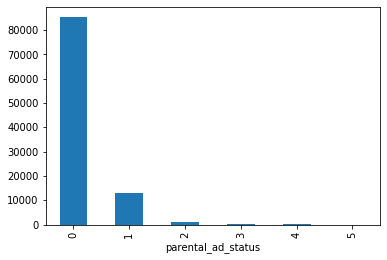

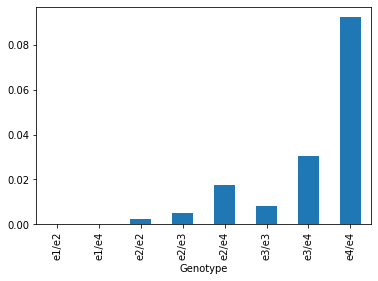

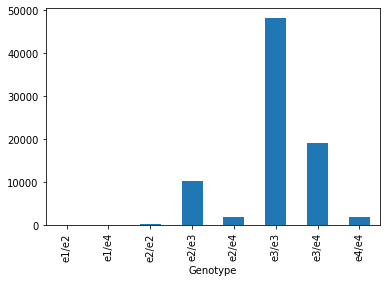

In [64]:
for var in shap_vars:
    if ukb_shap[var].nunique()<10:
       ukb_shap.groupby([var])['AD'].mean().plot(kind="bar")
       plt.show()
       ukb_shap.groupby([var]).size().plot(kind="bar")
       plt.show()
    if ukb_shap[var].nunique()>10 and ukb_shap[var].dtype=="float64":
       ukb_shap[var].hist()
       plt.show()
       ukb_shap.groupby([var])['AD'].mean().plot(kind="line")
       plt.show()
       ukb_shap.groupby([var]).size().plot(kind="line")
       plt.title=var
       plt.show()

In [24]:
ukb_shap['sleeplessness_insomnia_f1200'].count()/ukb_shap.shape[0]

0.9984454451543021

In [110]:
ukb_shap['mean_time_to_correctly_identify_matches_f20023']

0         656.0
1         509.0
2         633.0
3         598.0
4         540.0
          ...  
107879    765.0
107880    488.0
107881    664.0
107882    531.0
107883    622.0
Name: mean_time_to_correctly_identify_matches_f20023, Length: 107884, dtype: float64

In [90]:
col_filt=400000
cardin=100

ukb_cols_filt=[col for col in ukb_tp0.columns if 
               (ukb_tp0[col].count()>col_filt and len(ukb_tp0[col].value_counts())<cardin) 
               or col=='eid' or col in dis_vars]

ukb_filt0=ukb_tp0[ukb_cols_filt]

ukbfilttemp=pd.merge(ukb_filt0[['eid']],diseases_bin[dis_vars],left_on='eid',right_on='n_eid',how='left')
ukb_filt0[dis_vars]=ukbfilttemp[dis_vars]

age_mask=(ukb_filt0['Age_Today']>=75)

ukb_filt0=ukb_filt0[age_mask]

ukb_filt0['APOE4']=0
apoe_mask=(ukb_filt0['Genotype']=="e4/e4")|(ukb_filt0['Genotype']=="e3/e4")|(ukb_filt0['Genotype']=="e2/e4")
ukb_filt0['APOE4'][apoe_mask]=1

In [94]:
ukb_filt0['Age_Today'].max()

85.86849315068493

In [102]:
apoe_sum=pd.DataFrame(ukb_filt0.groupby(['APOE4']).agg({'AD':['mean']})).reset_index()
apoe_sum.columns=['APOE4','ADRate_avg']

,APOE4,ADRate_avg
0,0,0.008765
1,1,0.030282


In [106]:
def createvarsum(df,df1=apoe_sum):
    var_df=pd.DataFrame()
    for col in ukb_filt0.columns:
        if col !='eid' and col !='APOE4':
            df2=pd.DataFrame(df.groupby(['APOE4',col]).agg({'AD':['mean','count','sum']})).reset_index()
            df2.columns=['APOE4','breakdown','ADrate','recs','num_AD']
            df2=pd.merge(df2,df1,on='APOE4',how='inner')
            df2['ADrate']=df2['ADrate']/df2['ADRate_avg']
            df2['variable']=col
            var_df=pd.concat([var_df,df2],axis=0)
    return var_df

var_df=createvarsum(ukb_filt0,df1=apoe_sum)

In [107]:
var_df.to_csv('%s%s' % (path,'variablesummary.csv'))

In [180]:
ukb_tp0['AD']=ukb_tp0_dvars['AD']

In [173]:
ukb_tp0.to_csv('%s%s' % (path,'ukb_tp0.csv'))

In [78]:
df_full[(df_full['variable'].str.contains('matches'))]

,APOE4,breakdown,ADrate,recs,num_AD,ADRate_avg,variable
0,0,10,0.0,1,0.0,0.008765,rounded_matches_f20023
1,0,20,0.0,2,0.0,0.008765,rounded_matches_f20023
2,0,40,0.0,1,0.0,0.008765,rounded_matches_f20023
3,0,50,0.0,2,0.0,0.008765,rounded_matches_f20023
4,0,60,0.0,10,0.0,0.008765,rounded_matches_f20023
...,...,...,...,...,...,...,...
69,1,340,0.0,5,0.0,0.030282,rounded_matches_f20023
70,1,350,0.0,2,0.0,0.030282,rounded_matches_f20023
71,1,360,0.0,1,0.0,0.030282,rounded_matches_f20023
72,1,370,0.0,1,0.0,0.030282,rounded_matches_f20023


In [122]:
ukb_tp0_dvars=pd.merge(ukb_tp0[vars_analyse],
               diseases_bin[['n_eid','Age_Today','AD','Diag_Date_AD','years_bef_diagAD',
                           'date_of_attending_assessment_centre_f53', 'age_when_attended_assessment_centre_f21003',
                           'EPIL','DIAB','CELIAC','CERVASC','EPIL_bef','DIAB_bef']],
                      left_on='eid',right_on='n_eid',how='left')

In [125]:
ukb_tp0_score.columns

Index(['eid', 'Genotype', 'recent_feelings_of_depression_f20510',
       'sleeplessness_insomnia_f1200', 'parental_ad_status',
       'particulate_matter_air_pollution_pm25_2010_f24006',
       'number_of_symbol_digit_matches_made_correctly_f20159', 'sex_f31',
       'type_of_special_diet_followed_f20086',
       'ever_used_hormonereplacement_therapy_hrt_f2814', 'n_eid', 'Age_Today',
       'AD', 'Diag_Date_AD', 'years_bef_diagAD',
       'date_of_attending_assessment_centre_f53',
       'age_when_attended_assessment_centre_f21003', 'EPIL', 'DIAB', 'CELIAC',
       'CERVASC', 'EPIL_bef', 'DIAB_bef', 'mean_score', 'std_score'],
      dtype='object')

In [124]:
ukb_tp0_score=pd.merge(ukb_tp0_dvars,scoredf,on='eid',how='inner')

In [126]:
ukb_tp0_score.to_csv('%s%s' % (path,'ukb_tp0_score.csv'))

In [ ]:
def ageunits(df):
    ukb_time=df[['eid','Diag_Date_AD','AD','age_when_attended_assessment_centre_f21003',
                        'years_bef_diagAD', 'date_of_attending_assessment_centre_f53']]
    ukb_time['age']=ukb_time['age_when_attended_assessment_centre_f21003']
    ukb_time['years_fwd']=(dt.datetime.strptime('2020-01-01', '%Y-%m-%d')-\
    pd.to_datetime(ukb_time['date_of_attending_assessment_centre_f53'])).dt.days/365
    ukb_time=ukb_time[pd.notnull(ukb_time['years_fwd'])]

    ukb_time['time']=0
    new_rows = []
    for i, row in ukb_time.iterrows():
        for j in range(int(row['years_fwd'])): 
            row['time'] = j
            row['age']=row['age_when_attended_assessment_centre_f21003']+j
            newrow = row.copy()
            new_rows.append(newrow.values)


    ukb_time_full = pd.DataFrame(new_rows, columns=ukb_time.columns).reset_index()
    return ukb_time_full
    

In [ ]:
ukb_time_full=ageunits(ukb_tp0_dvars)

In [16]:
%%time
ukb_time=ukb_tp0_dvars[['eid','Diag_Date_AD','AD','age_when_attended_assessment_centre_f21003',
                        'years_bef_diagAD', 'date_of_attending_assessment_centre_f53']]

ukb_time['age']=ukb_time['age_when_attended_assessment_centre_f21003']
ukb_time['years_fwd']=(dt.datetime.strptime('2020-01-01', '%Y-%m-%d')-\
pd.to_datetime(ukb_time['date_of_attending_assessment_centre_f53'])).dt.days/365
ukb_time=ukb_time[pd.notnull(ukb_time['years_fwd'])]

ukb_time['time']=0
new_rows = []
for i, row in ukb_time.iterrows():
    for j in range(int(row['years_fwd'])): 
        row['time'] = j
        row['age']=row['age_when_attended_assessment_centre_f21003']+j
        newrow = row.copy()
        new_rows.append(newrow.values)
        

ukb_time_full = pd.DataFrame(new_rows, columns=ukb_time.columns).reset_index()

CPU times: user 25min 32s, sys: 43.4 s, total: 26min 15s
Wall time: 26min 15s


In [68]:
findcols(ukb_tp0_dvars,'CE')

['CELIAC']

In [25]:
ukb_time_full2=pd.merge(ukb_time,ukb_tp0_dvars[['eid','diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068',
                                               'EPIL','DIAB','EPIL_bef','DIAB_bef']],on='eid',how='left')

In [18]:
def drawline(df,varx,vary,huevar):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data = df, x=varx, y=vary, hue=huevar)

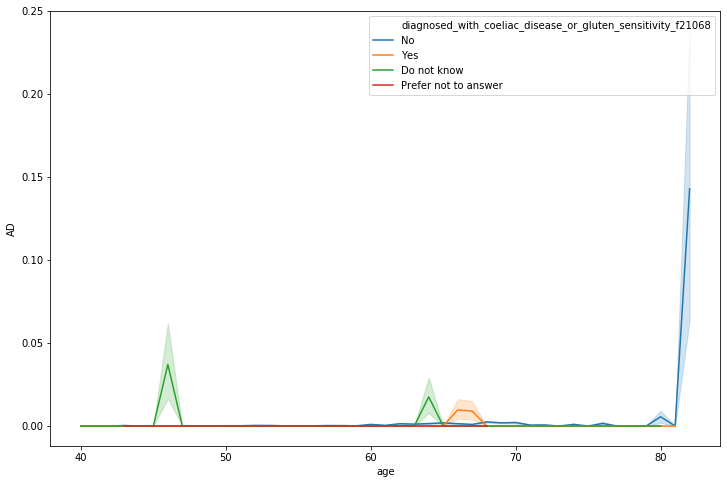

In [19]:
drawline(ukb_time_full2,"age","AD",'diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068')

In [96]:
ukb_tp0_dvars[(ukb_tp0_dvars['sex_f31']=="Female")].groupby(['ever_used_hormonereplacement_therapy_hrt_f2814'])['AD'].mean()

ever_used_hormonereplacement_therapy_hrt_f2814
Do not know             0.011127
No                      0.003351
Prefer not to answer    0.003788
Yes                     0.006556
Name: AD, dtype: float64

In [95]:
ukb_tp0_dvars['sex_f31'].value_counts()

Female    273378
Male      229115
Name: sex_f31, dtype: int64

In [94]:
findcols(ukb_tp0_dvars,'sex')

['sex_f31']

In [32]:
rule_coeliac=(ukb_tp0_dvars['diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068']=="Yes")
rule_coeliacno=(ukb_tp0_dvars['diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068']=="No")
rule_diaby=(ukb_tp0_dvars['DIAB_bef']==1)
rule_diabn=(ukb_tp0_dvars['DIAB_bef']==0)
rule_epily=(ukb_tp0_dvars['EPIL_bef']==1)
rule_epiln=(ukb_tp0_dvars['EPIL_bef']==0)
rule_age=(ukb_tp0_dvars['Age_Today']>75)
rule_AD=(ukb_tp0_dvars['AD']==1)

In [57]:
mask=(pd.isnull(ukb_tp0_dvars['diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068']))
ukb_tp0_dvars['diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068'][mask]="Missing"

In [75]:
findcols(ukb_tp0,'f20086')

['type_of_special_diet_followed_f20086']

In [81]:
ukb_tp0_dvars.groupby(['type_of_special_diet_followed_f20086'])['AD'].mean()

type_of_special_diet_followed_f20086
Gluten-free     0.004782
Lactose-free    0.002986
Low calorie     0.003086
Other           0.002945
Vegan           0.000000
Vegetarian      0.001918
Name: AD, dtype: float64

In [80]:
ukb_tp0_dvars.groupby(['AD'])['CERVASC'].sum()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [31]:
print(ukb_tp0_dvars[rule_diaby&rule_age]['AD'].mean())
print(ukb_tp0_dvars[rule_diabn&rule_age]['AD'].mean())

0.009862064369960686
0.01331081752259859


In [33]:
print(ukb_tp0_dvars[rule_epily&rule_age]['AD'].mean())
print(ukb_tp0_dvars[rule_epiln&rule_age]['AD'].mean())

0.03458957150232318
0.012559871412763414


In [61]:
ukb_tp0_dvars[rule_coeliac&rule_age]

,eid,diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068,n_eid,Age_Today,AD,Diag_Date_AD,years_bef_diagAD,date_of_attending_assessment_centre_f53,age_when_attended_assessment_centre_f21003,EPIL,DIAB
812,1009346,Yes,1009346.0,81.024658,0.0,None,NaN,2008-09-25,69.0,0.0,0.0
3088,1035528,Yes,1035528.0,75.167123,0.0,None,NaN,2009-08-04,64.0,0.0,0.0
4067,1046921,Yes,1046921.0,78.608219,0.0,None,NaN,2010-02-24,68.0,0.0,0.0
7280,1083940,Yes,1083940.0,78.241096,0.0,None,NaN,2008-07-08,66.0,0.0,0.0
7553,1087036,Yes,1087036.0,75.717808,0.0,None,NaN,2009-01-15,64.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
491654,5180927,Yes,5180927.0,75.293151,0.0,None,NaN,2008-06-19,63.0,0.0,0.0
493032,5288215,Yes,5288215.0,78.353425,0.0,None,NaN,2010-05-28,68.0,0.0,0.0
494931,5436855,Yes,5436855.0,80.112329,0.0,None,NaN,2009-08-24,69.0,0.0,0.0
495076,5447330,Yes,5447330.0,80.301370,0.0,None,NaN,2009-06-16,69.0,0.0,0.0


In [52]:
ukb_tp0_dvars[rule_coeliacno].shape


(170094, 11)

In [58]:
ukb_tp0_dvars[rule_coeliacno&rule_age]['AD'].mean()

0.002160790231856222

In [59]:
ukb_tp0_dvars[rule_age]['AD'].mean()

0.013747538831765478

In [42]:
ukb_tp0_dvars.shape

(4117737, 13)

In [43]:
findcols(ukb_tp0,'APOE')

['APOE4_Carriers']

In [48]:
[col for col in ukb_tp0.columns if 'genotype' in col]

['chromosome_10_genotype_results_f22110',
 'chromosome_11_genotype_results_f22111',
 'chromosome_12_genotype_results_f22112',
 'chromosome_13_genotype_results_f22113',
 'chromosome_14_genotype_results_f22114',
 'chromosome_15_genotype_results_f22115',
 'chromosome_16_genotype_results_f22116',
 'chromosome_17_genotype_results_f22117',
 'chromosome_18_genotype_results_f22118',
 'chromosome_19_genotype_results_f22119',
 'chromosome_1_genotype_results_f22101',
 'chromosome_20_genotype_results_f22120',
 'chromosome_21_genotype_results_f22121',
 'chromosome_22_genotype_results_f22122',
 'chromosome_2_genotype_results_f22102',
 'chromosome_3_genotype_results_f22103',
 'chromosome_4_genotype_results_f22104',
 'chromosome_5_genotype_results_f22105',
 'chromosome_6_genotype_results_f22106',
 'chromosome_7_genotype_results_f22107',
 'chromosome_8_genotype_results_f22108',
 'chromosome_9_genotype_results_f22109',
 'chromosome_x_genotype_results_f22123',
 'chromosome_xy_genotype_results_f22100',
 '

In [44]:
ukb_tp0['APOE4_Carriers'].value_counts()

0.0    961404
1.0    324129
2.0     29496
Name: APOE4_Carriers, dtype: int64